In [22]:
import timeit
import numpy as np
from scipy.linalg import cho_factor, cho_solve

import matplotlib.pyplot as plt

rng = np.random.default_rng(500)

In [23]:
def generate_cov(mat_size=500, min_val=0, max_val=1):
    A = rng.uniform(min_val, max_val, size=(mat_size, mat_size))
    return A @ A.T

def _inv2x2(A):
    '''In-place'''
    a = (1/(A[0, 0]*A[1, 1] - A[0, 1]*A[1, 0]))
    A[0, 0], A[0, 1], A[1, 0], A[1, 1] = A[1, 1], -A[0, 1], -A[1, 0], A[0, 0]
    A *=a

def smw(A_inv, U, V, out=None):
    '''
    Args:
        A_inv (N x N): inverse calculated in the  previous step
    '''
#     assert (A_inv.shape[0] == A_inv.shape[1]), 'A should be square matrix N x N'
#     assert ((A_inv.shape[0], 2) == U.shape == V.T.shape), f'U and V.T should be column vectors N x 2. Seen U {U.shape}, V {V.T.shape}'
#     assert (1 + v.T @ A_inv @ u != 0), 'Formula condition that the calculated value represents the inverse'
    
    if out is not None:
        A_inv = out
    
    t1 = (A_inv @ U)
    # t2 = np.linalg.inv(np.identity(2) + V @ t1)
    t2 = np.identity(2) + V @ t1
    _inv2x2(t2)

    t3 = V @ A_inv
    
    if out is not None:
        A_inv -= t1 @ t2 @ t3
    else:
        return A_inv - t1 @ t2 @ t3


A = generate_cov()

In [24]:
max_mat_size = 3_000
step = 100

In [25]:
# Inverse with no assumptions
times_inv = np.zeros(max_mat_size)
for size in range(1, max_mat_size, step):
    A = generate_cov(mat_size=size)
    timer_start = timeit.default_timer()
    np.linalg.inv(A)
    timer_end = timeit.default_timer()
    times_inv[size] = timer_end - timer_start
    
    if (size-1) % 50 == 0:
        print(f'Shape {A.shape}', end='\r')
print(80*'-')
print('Finished')

--------------------------------------------------------------------------------
Finished


In [26]:
# Inverse with cholesky
times_cho = np.zeros(max_mat_size)
for size in range(1, max_mat_size, step):
    A = generate_cov(mat_size=size)
    iden = np.identity(size)
    timer_start = timeit.default_timer()
#     L = np.linalg.cholesky(A)
    cho_solve(cho_factor(A + np.diag(np.ones_like(A) * 1e-7), lower=True), iden)
    timer_end = timeit.default_timer()
    times_cho[size] = timer_end - timer_start

In [27]:
# Inverse with smw
times_smw = np.zeros(max_mat_size)
for size in range(1, max_mat_size, step):
    A = generate_cov(mat_size=size)
    
    # Used in algo around smw
    ##########################
    U = np.zeros((A[-1].size, 2))
    
    U[:-1, 1] = A[:-1, -1:].ravel()
    U[-1, 0] = 1

    V = np.zeros((2, A[-1].size))
    V[0, :] = U[:,1]
    V[1, -1] = 1
    
    smw(A, U, V)
    ##########################
    
    timer_start = timeit.default_timer()
    timer_end = timeit.default_timer()
    times_smw[size] = timer_end - timer_start


                    


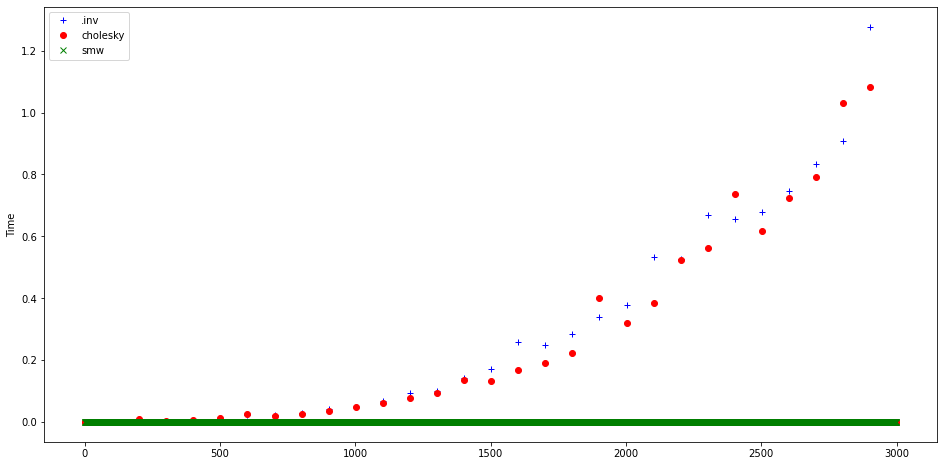

In [28]:
plt.figure(figsize=(16, 8))

plt.plot(range(1, max_mat_size), times_inv[:-1], 'b+', label='.inv')
plt.plot(range(1, max_mat_size), times_cho[:-1], 'ro', label='cholesky')
plt.plot(range(1, max_mat_size), times_smw[:-1], 'gx', label='smw')

plt.ylabel('Time')
plt.legend()